### Your very own neural network

In this notebook, we're going to build a neural network using naught but pure numpy and steel nerves. It's going to be fun, I promise!

![img](https://s27.postimg.org/vpui4r5n7/cartoon-2029952_960_720.png)

In [1]:
from __future__ import print_function
import numpy as np
import warnings

np.random.seed(42)

Here goes our main class: a layer that can .forward() and .backward().

In [2]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__ (self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self,input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### The road ahead

We're going to build a neural network that classifies MNIST digits. To do so, we'll need a few building blocks:
- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (or any other nonlinearity you want)
- Loss function - crossentropy
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.


### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [3]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(input,0)

    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad        

In [4]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
print(grads.shape)
print(numeric_grads.shape)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

(10, 32)
(10, 32)


#### Instant primer: lambda functions

In python, you can define functions in one line using the `lambda` syntax: `lambda param1, param2: expression`

For example: `f = lambda x, y: x+y` is equivalent to a normal function:

```
def f(x,y):
    return x+y
```
For more information, click [here](http://www.secnetix.de/olli/Python/lambda_functions.hawk).    

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size,num_features],
* W is a weight matrix [batch_size,num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called.

In [31]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ

        self.weights = np.random.randn(input_units, output_units)*0.01

        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights)+self.biases
    
    def backward(self,input,grad_output,verbose=False):
  
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed

       
        grad_input=np.dot(grad_output,self.weights.transpose())
        grad_biases = grad_output.mean(axis=0)
   
        dfddense=grad_output
    #.mean(axis=0,keepdims=True)
      
        ddensedw=input.T
        #.mean(axis=0,keepdims=True).transpose()
        grad_weights=np.dot(ddensedw,dfddense)/input.shape[0]
        #.mean(axis=0)         
        
      
                
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate*grad_weights
        self.biases = self.biases - self.learning_rate*grad_biases
        
        return grad_input

### Testing the dense layer

Here we have a few tests to make sure your dense layer works properly. You can just run them, get 3 "well done"s and forget they ever existed.

... or not get 3 "well done"s and go fix stuff. If that is the case, here are some tips for you:
* Make sure you compute gradients for W and b as __mean gradient over batch__, not sums of gradients.
* If you're debugging, try saving gradients in class fields, like "self.grad_w = grad_w" or print first 3-5 weights. This helps debugging.
* If nothing else helps, try ignoring tests and proceed to network training. If it trains alright, you may be off by something that does not affect network training.

In [29]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)
print(l.forward(x).shape)
print(np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]).shape)
    
assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

(2, 4)
(2, 4)
Well done!


In [32]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*77).reshape([10,77])
x=np.ones_like(x)
l = Dense(77,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))
print(numeric_grads.shape)
print(grads.shape)
assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

(10, 77)
(10, 77)
Well done!


In [33]:
# Test the gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]))
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)
print(numeric_dw.shape,grad_w.shape)
print(numeric_db.shape,grad_b.shape)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

(32, 64) (32, 64)
(64,) (64,)
Well done!


### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If you write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If you take a closer look, ya'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [9]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch, n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch, n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return - ones_for_answers + softmax

In [10]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

#softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).sum(),logits)
print(grads.shape)
print(numeric_grads.shape)
assert np.allclose(numeric_grads, grads, rtol=1e-3, atol=0),\
    "The reference implementation has just failed. That is bizzare."

(50, 10)
(50, 10)


### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

Using TensorFlow backend.


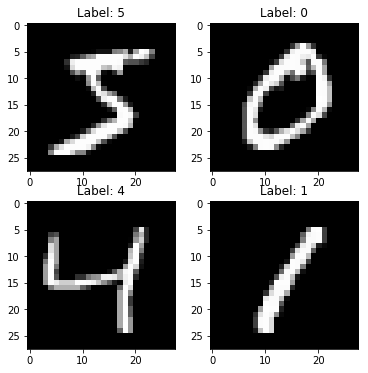

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [34]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))




In [14]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
 
    for i,layer in enumerate(network):
        if i==0:
            activations.append(layer.forward(input))
        else:
            activations.append(layer.forward(activations[i-1]))           


#     x=np.zeros_like(activations[-1])
#     x[activations[-1]==np.amax(activations[-1],axis=1,keepdims=True)]=1
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # We start at the end, as we know the gradient
    reverse_inputs=layer_inputs[::-1]
    reverse_network=network[::-1]
    gradient=loss_grad
    for i,layer in enumerate(reverse_network):
                 
        gradient=layer.backward(reverse_inputs[i+1],gradient)        
        
    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [16]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
    

In [35]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 7
Train accuracy: 0.9916
Val accuracy: 0.9763


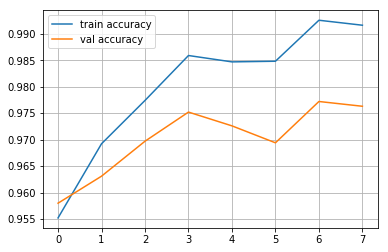

 16%|█▋        | 514/3125 [00:01<00:07, 327.24it/s]


KeyboardInterrupt: 

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter('error')
    for epoch in range(150):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=16,shuffle=True):
            train(network,x_batch,y_batch)

        train_log.append(np.mean(predict(network,X_train)==y_train))
        val_log.append(np.mean(predict(network,X_val)==y_val))

        clear_output()
        print("Epoch",epoch)
        print("Train accuracy:",train_log[-1])
        print("Val accuracy:",val_log[-1])
        plt.plot(train_log,label='train accuracy')
        plt.plot(val_log,label='val accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    

### Peer-reviewed assignment

Congradulations, you managed to get this far! There is just one quest left undone, and this time you'll get to choose what to do.


#### Option I: initialization
* Implement Dense layer with Xavier initialization as explained [here](http://bit.ly/2vTlmaJ)

To pass this assignment, you must conduct an experiment showing how xavier initialization compares to default initialization on deep networks (5+ layers).


#### Option II: regularization
* Implement a version of Dense layer with L2 regularization penalty: when updating Dense Layer weights, adjust gradients to minimize

$$ Loss = Crossentropy + \alpha \cdot \underset i \sum {w_i}^2 $$

To pass this assignment, you must conduct an experiment showing if regularization mitigates overfitting in case of abundantly large number of neurons. Consider tuning $\alpha$ for better results.

#### Option III: optimization
* Implement a version of Dense layer that uses momentum/rmsprop or whatever method worked best for you last time.

Most of those methods require persistent parameters like momentum direction or moving average grad norm, but you can easily store those params inside your layers.

To pass this assignment, you must conduct an experiment showing how your chosen method performs compared to vanilla SGD.

### General remarks
_Please read the peer-review guidelines before starting this part of the assignment._

In short, a good solution is one that:
* is based on this notebook
* runs in the default course environment with Run All
* its code doesn't cause spontaneous eye bleeding
* its report is easy to read.

_Formally we can't ban you from writing boring reports, but if you bored your reviewer to death, there's noone left alive to give you the grade you want._


### Bonus assignments

As a bonus assignment (no points, just swag), consider implementing Batch Normalization ([guide](https://gab41.lab41.org/batch-normalization-what-the-hey-d480039a9e3b)) or Dropout ([guide](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)). Note, however, that those "layers" behave differently when training and when predicting on test set.

* Dropout:
  * During training: drop units randomly with probability __p__ and multiply everything by __1/(1-p)__
  * During final predicton: do nothing; pretend there's no dropout
  
* Batch normalization
  * During training, it substracts mean-over-batch and divides by std-over-batch and updates mean and variance.
  * During final prediction, it uses accumulated mean and variance.


## Option 1
Xavier initialization

We have just seen how a network works, but it was too shallow. I will first implement a layer with Xavier initialisation following the Glorot-Bengio formulation [here](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)

$Var(W_i)=\frac {2}{n_{in}}$ or

$Var(W_i)=\frac {2}{n_{in}+n_{out}}$



In [37]:
class DenseXavier(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1,xavier_o=False):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        #Truncate to avoid dead relus
        if xavier_o:
            x_var=np.sqrt(2/(input_units+output_units))
        else:
            x_var=np.sqrt(2/(input_units))
        self.weights = np.random.randn(input_units, output_units)*x_var
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights)+self.biases
    
    def backward(self,input,grad_output,verbose=False):
  
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed

       
        grad_input=np.dot(grad_output,self.weights.transpose())
        
        if verbose:
            print(grad_output.shape)
            print(self.weights.shape)
            print("grad input",grad_input.shape)
            print("input",input.shape)
        
        # compute gradient w.r.t. weights and biases
        #This is df / dW =  df/DDense*dDense/dW 
        #dDense/dW=input.transposed()
        #df/dW has dimensions of [input,output]
        #df/dDDense has dimensions of [batch,output]
        #dDense/dW has dims of [input,output]
      
        grad_biases = grad_output.mean(axis=0)
   
        dfddense=grad_output
      
        ddensedw=input.transpose()
        grad_weights=np.dot(ddensedw,dfddense)/input.shape[0]        
        
               
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate*grad_weights
        self.biases = self.biases - self.learning_rate*grad_biases
        
        return grad_input

I define three deep nets, and will train them in parallel to see what happens.

All of them have five layers, the first one uses the default initialization with std 0.01, the second one uses the first formulation of Xavier initialisation, just taking into account the number of input units. The third one uses both the number of input and output units to initialise the network.

In [42]:
N_NEURONS=50
LRATE=0.1
network_basic=[]
#Layer 1
network_basic.append(Dense(X_train.shape[1],N_NEURONS,learning_rate=LRATE))
network_basic.append(ReLU())
#Layer2
network_basic.append(Dense(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_basic.append(ReLU())
#Layer3
network_basic.append(Dense(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_basic.append(ReLU())
#Layer4
network_basic.append(Dense(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_basic.append(ReLU())
#Layer 5
network_basic.append(Dense(N_NEURONS,10,learning_rate=LRATE))

network_xavier=[]
#Layer 1
network_xavier.append(DenseXavier(X_train.shape[1],N_NEURONS,learning_rate=LRATE))
network_xavier.append(ReLU())
#Layer2
network_xavier.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_xavier.append(ReLU())
#Layer3
network_xavier.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_xavier.append(ReLU())
#Layer4
network_xavier.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_xavier.append(ReLU())
#Layer 5
network_xavier.append(DenseXavier(N_NEURONS,10,learning_rate=LRATE))

network_xavier2=[]
#Layer 1
network_xavier2.append(DenseXavier(X_train.shape[1],N_NEURONS,learning_rate=LRATE,xavier_o=True))
network_xavier2.append(ReLU())
#Layer2
network_xavier2.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE,xavier_o=True))
network_xavier2.append(ReLU())
#Layer3
network_xavier2.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE,xavier_o=True))
network_xavier2.append(ReLU())
#Layer4
network_xavier2.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE,xavier_o=True))
network_xavier2.append(ReLU())
#Layer 5
network_xavier2.append(DenseXavier(N_NEURONS,10,learning_rate=LRATE,xavier_o=True))

In [43]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [44]:
from IPython.display import clear_output
train_log_basic = []
val_log_basic = []

train_log_xavier = []
val_log_xavier = []

train_log_xavier2 = []
val_log_xavier2 = []

Epoch 1
Train accuracy(Basic): 0.09936 | Train accuracy(Xavier) 0.96532 | Train accuracy(Xavier2) 0.9651 |


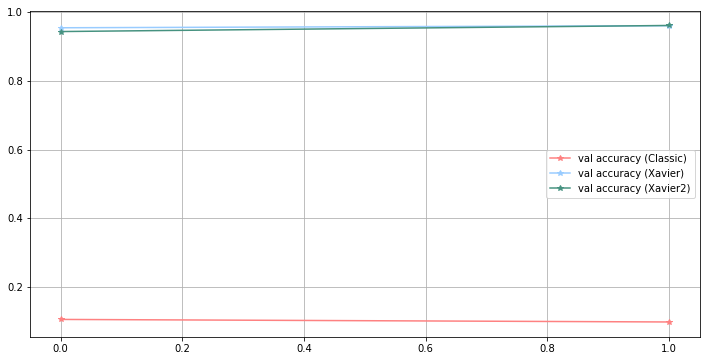

 69%|██████▊   | 2147/3125 [00:12<00:05, 171.83it/s]

KeyboardInterrupt: 

In [45]:

for epoch in range(25):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=16,shuffle=True):
            train(network_basic,x_batch,y_batch)
            train(network_xavier,x_batch,y_batch)
            train(network_xavier2,x_batch,y_batch)

        train_log_basic.append(np.mean(predict(network_basic,X_train)==y_train))
        val_log_basic.append(np.mean(predict(network_basic,X_val)==y_val))
        
        train_log_xavier.append(np.mean(predict(network_xavier,X_train)==y_train))
        val_log_xavier.append(np.mean(predict(network_xavier,X_val)==y_val))
        
        train_log_xavier2.append(np.mean(predict(network_xavier2,X_train)==y_train))
        val_log_xavier2.append(np.mean(predict(network_xavier2,X_val)==y_val))

        clear_output()
        print("Epoch",epoch)
        print("Train accuracy(Basic):",train_log_basic[-1],"|",
              "Train accuracy(Xavier)",train_log_xavier[-1],"|",
              "Train accuracy(Xavier2)",train_log_xavier2[-1],"|"
             )
        #print("Val accuracy(Xasic):",val_log_basic[-1],"Train accuracy(Xavier)",train_log_basic[-1])
        plt.figure(figsize=(12,6))
        #plt.plot(train_log_basic,label='train accuracy (Classic)',color="red")
        plt.plot(val_log_basic,label='val accuracy (Classic)',color="#fe8181",marker="*")
        
        #plt.plot(train_log_xavier,label='train accuracy (Xavier)',color="blue")
        plt.plot(val_log_xavier,label='val accuracy (Xavier)',color="#99ccff",marker="*")
        
        plt.plot(val_log_xavier2,label='val accuracy (Xavier2)',color="#469280",marker="*")
        
        plt.legend(loc='best')
        plt.grid()    
 
        plt.show()
    

Usually, it would be necessary to conduct several tests and average, due to the stochastic nature of training neural nets. Here, however, it becomes quite clear that Xavier initialisation provides a massive boost to the training. In this particular case, with the same learning rate and network architecture, the Xavier nets are already at >0.6 in accuracy after the first pass, while the classic network takes a very long time to get better. 

This is because even though the network has the capacity to be as good as the xavier nets, the gradients are not being propagated adequately through the net.

Note that the Xavier network, even though it has more capacity than our previous network, was not able to go above 0.97. Perhaps using momentum or other technique would help in this case.

## Batch normalisation

As described by Szegedy et al. [here](https://arxiv.org/pdf/1502.03167.pdf) .

We start by definig a batchnorm class.

I will initialise $\gamma=1$, $\beta=0$, and $m=0.99$ (for the moving average)

In [46]:
class BatchNorm(Layer):
    def __init__(self,n_input, learning_rate=0.1):
        """A BatchNorm layer. It normalises the outputs in such a way
        so that there is no distribution shift between layers"""
        self.gamma=np.ones((1,n_input))
        self.beta=np.zeros((1,n_input))
        self.m=0.99
        self.eps=0.001
        self.learning_rate=learning_rate
        self.mu_w=None
        self.var_w=None
        
    
    def forward(self, input, predict = False):
        """Apply elementwise batchnorm to [batch, input_units] matrix
        As we go, take a rolling mean of mu and var.
        Use those for prediction"""
        if predict:
            m=input.shape[0]
            mub=self.mu_w
            varb=self.var_w*(m/(m-1))
            y1=self.gamma/np.sqrt(varb+self.eps)*input
            y2=(self.beta-self.gamma*mub/np.sqrt(varb+self.eps))
            return y1+y2
        else:
            mub=np.mean(input,axis=0,keepdims=True)
            varb=np.var(input,axis=0,keepdims=True) 
            if self.mu_w is None or self.var_w is None:
                self.mu_w = mub
                self.var_w = varb
            else:
                self.mu_w=self.m*self.mu_w+(1-self.m)*mub
                self.var_w=self.m*self.var_w+(1-self.m)*varb
            
        xhat= (input-mub)/np.sqrt(varb+self.eps)
        return self.gamma*xhat+self.beta

    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. batchnorm input"""
        
        mub=np.mean(input,axis=0,keepdims=True)
        varb=np.var(input,axis=0,keepdims=True)
        xhat= (input-mub)/np.sqrt(varb+self.eps)
        m=input.shape[0]

        #As a reminder, grad_output is dl/doutput
        #grad_input is dl/dinput=dl/dlayer*dlayer/dinput
        
        #grad_dhat=dl/doutput times gamma
        grad_xhat=self.gamma*grad_output 
        
        assert grad_xhat.shape == grad_output.shape
        
        #grad_var is explained in the paper
        k=-0.5*(varb+self.eps)**(-3/2)
        
        
        grad_var=np.sum(grad_xhat*(input-mub),axis=0,keepdims=True)*k
        
        assert grad_var.shape == varb.shape
        
        #grad_mu is explained in the paper
        k2=-1/np.sqrt(varb+self.eps)
        grad_mu1=np.sum(grad_xhat*k2,axis=0,keepdims=True)
        grad_mu2=grad_var*(-2*np.sum(input-mub,axis=0,keepdims=True))/m
        grad_mu=grad_mu1+grad_mu2
        
        assert grad_mu.shape == mub.shape
        
        #grad_gamma=dot of dl/doutput imes xhat        
        grad_gamma=np.mean(grad_output*xhat,axis=0,keepdims=True)
        
        #grad_beta = sum of dl/doutput
        grad_beta=np.mean(grad_output,axis=0,keepdims=True)
        
        #grad_input is explained in the paper
       
        grad_input1=-k2*grad_xhat
        grad_input2=grad_var*(2/m)*(input-mub)
        grad_input3=grad_mu/m
        grad_input=grad_input1+grad_input2+grad_input3
        
        assert grad_input.shape == input.shape
        
        assert grad_output.shape == grad_input.shape


        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.gamma = self.gamma - self.learning_rate*grad_gamma
        self.beta = self.beta - self.learning_rate*grad_beta       
        
        return grad_input

We also have to redefine forward and predict to account for a layer that behaves differently. I could also redefine the classes to take an extra parameter, but life's too short

In [47]:
def forward(network, X, predict=False):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
 
    for i,layer in enumerate(network):
        if i==0:
            if layer.__class__.__name__=="BatchNorm":
                activations.append(layer.forward(input,predict))
            else:
                activations.append(layer.forward(input))
        else:
            if layer.__class__.__name__=="BatchNorm":
                activations.append(layer.forward(activations[i-1],predict)) 
            else:
                activations.append(layer.forward(activations[i-1]))           


    x=np.zeros_like(activations[-1])
    x[activations[-1]==np.amax(activations[-1],axis=1,keepdims=True)]=1
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X,predict=True)[-1]
    return logits.argmax(axis=-1)

 69%|██████▊   | 2147/3125 [00:30<00:13, 71.47it/s] 

### Tests for batchnorm

In [48]:
#Forward
bn=BatchNorm(n_input=4)

MEAN=2
STD=3
bn.beta=MEAN
bn.gamma=STD

test_batch=np.array([[1,0,1,-1],
                     [1,3,1,5],
                     [1,1,-10,1],
                     [1,4,5,6],
                     [2,2,1,3]])
output=bn.forward(test_batch)
print(output)
print("Mean ",np.mean(output,axis=0))
print("Var ",np.var(output,axis=0))

assert np.allclose(np.var(output,axis=0),STD*STD,rtol=1e-2)
assert np.allclose(np.mean(output,axis=0),MEAN,rtol=1e-2)
assert output.shape==test_batch.shape
assert np.mean(output,axis=0).shape==(test_batch.shape[1],)
assert np.var(output,axis=0).shape==(test_batch.shape[1],)

[[ 0.50466564 -2.24158042  2.8326878  -2.450613  ]
 [ 0.50466564  4.12079021  2.8326878   4.57667069]
 [ 0.50466564 -0.12079021 -3.7098592  -0.10818511]
 [ 0.50466564  6.24158042  5.2117958   5.74788463]
 [ 7.98133744  2.          2.8326878   2.23424279]]
Mean  [ 2.  2.  2.  2.]
Var  [ 8.94409938  8.99550225  8.99964624  8.99862826]


In [49]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

N= 11
x = np.linspace(-1,1,10*N).reshape([10,N])
l = BatchNorm(n_input=N)
l.beta=2
l.gamma=7

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,N]))
print(numeric_grads.shape)
print(grads.shape)
try:
    assert np.allclose(grads,numeric_grads,rtol=1e-4,atol=1e-3)
except:    
    raise AssertionError("input gradient does not match numeric grad")
print("Well done!")

(10, 11)
(10, 11)
Well done!


In [50]:
# Test the gradients w.r.t. params
def compute_out_given_wb(gamma,beta):
    l = BatchNorm(n_input=32,learning_rate=1)
    l.gamma = gamma
    l.beta = beta
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(gamma,beta):
    l = BatchNorm(n_input=32,learning_rate=1)
    l.gamma = gamma
    l.beta = beta
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,32]))
    return gamma - l.gamma, beta - l.beta
    
beta, gamma = 2+np.zeros((1,32)),3*np.ones((1,32))

numeric_dw = eval_numerical_gradient(lambda gamma: compute_out_given_wb(gamma,beta).mean(0).sum(),gamma )
numeric_db = eval_numerical_gradient(lambda beta: compute_out_given_wb(gamma,beta).mean(0).sum(),beta )
grad_gamma,grad_beta = compute_grad_by_params(gamma,beta)
print(numeric_dw.shape,grad_gamma.shape)
print(numeric_db.shape,grad_beta.shape)
print(numeric_dw-grad_gamma)
print(numeric_db)
print(grad_beta)
assert np.allclose(numeric_dw,grad_gamma,rtol=1e-3,atol=1e-3), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_beta,rtol=1e-3,atol=1e-3), "weight gradient does not match numeric weight gradient"
print("Well done!")

(1, 32) (1, 32)
(1, 32) (1, 32)
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
Well done!


We can now test batchnorm vs a baseline network to see what happens

In [51]:
N_NEURONS=50
LRATE=0.1
network_base=[]
#Layer 1
network_base.append(DenseXavier(X_train.shape[1],N_NEURONS,learning_rate=LRATE))
network_base.append(ReLU())
#Layer2
network_base.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_base.append(ReLU())
#Layer3
network_base.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_base.append(ReLU())
#Layer4
network_base.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_base.append(ReLU())
#Layer 5
network_base.append(DenseXavier(N_NEURONS,10,learning_rate=LRATE))

network_bn=[]
#Layer 1
network_bn.append(DenseXavier(X_train.shape[1],N_NEURONS,learning_rate=LRATE))
network_bn.append(ReLU())
network_bn.append(BatchNorm(N_NEURONS,learning_rate=LRATE))
#Layer2
network_bn.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_bn.append(ReLU())
network_bn.append(BatchNorm(N_NEURONS,learning_rate=LRATE))
#Layer3
network_bn.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_bn.append(ReLU())
network_bn.append(BatchNorm(N_NEURONS,learning_rate=LRATE))
#Layer4
network_bn.append(DenseXavier(N_NEURONS,N_NEURONS,learning_rate=LRATE))
network_bn.append(ReLU())
network_bn.append(BatchNorm(N_NEURONS,learning_rate=LRATE))
#Layer 5
network_bn.append(DenseXavier(N_NEURONS,10,learning_rate=LRATE))

In [52]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
from IPython.display import clear_output

train_log_base = []
val_log_base = []

train_log_bn = []
val_log_bn = []

Epoch 11
Train accuracy (base): 0.98166
Train accuracy (bn): 0.98176
Val accuracy (base): 0.9683
Val accuracy (bn): 0.9733


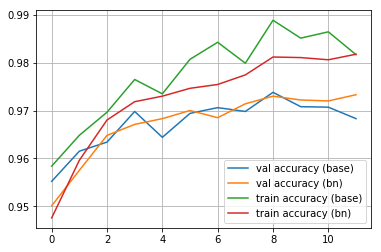

 32%|███▏      | 1014/3125 [00:08<00:16, 125.75it/s]


KeyboardInterrupt: 

In [54]:

for epoch in range(150):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=16,shuffle=True):
            train(network_bn,x_batch,y_batch)
            train(network_base,x_batch,y_batch)

        train_log_base.append(np.mean(predict(network_base,X_train)==y_train))
        val_log_base.append(np.mean(predict(network_base,X_val)==y_val))
        
        train_log_bn.append(np.mean(predict(network_bn,X_train)==y_train))
        val_log_bn.append(np.mean(predict(network_bn,X_val)==y_val))

        clear_output()
        print("Epoch",epoch)
        print("Train accuracy (base):",train_log_base[-1])
        print("Train accuracy (bn):",train_log_bn[-1])
        print("Val accuracy (base):",val_log_base[-1])
        print("Val accuracy (bn):",val_log_bn[-1])
        
        plt.plot(val_log_base,label='val accuracy (base)')
        plt.plot(val_log_bn,label='val accuracy (bn)')
        plt.plot(train_log_base,label='train accuracy (base)')
        plt.plot(train_log_bn,label='train accuracy (bn)')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    

We can see that batchnorm initially converges faster, and the variance in its trace is much smaller than the baseline. However, the baseline outperforms batchnorm after enough iterations. I suspect my implementation of batchnorm is not correct, but I can't figure out why.